In [1]:
import os

import time

import numpy as np
import pandas as pd
from scipy.stats import reciprocal

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV

#Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras


import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

from keras.utils import np_utils



In [2]:
dataset = pd.read_csv("A_Z Handwritten Data.csv").astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)

# Splite data the X - Our data , and y - the prdict label
X_f = dataset.drop('label',axis = 1)
y_f = dataset['label']



## abbiamo quindi uno sbilanciamento che penalizza la I e la F 


dato che il nostro dataset è molto numeroso uso il metodo RandomUnderSampler per andare a equilibrare il numero di  dati al pari della popolosità di I ( 1120*26 = 29120)

In [3]:
##per avere dei dati confrontabili estrapolo lo stesso test train 
X, X_test, y, y_test = train_test_split( X_f, y_f, test_size=0.20 , random_state=42)
X_test_ns = X_test.copy()

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_full, y_train_full = rus.fit_resample(X, y)
X_train_full.shape, y_train_full.shape


((22958, 784), (22958,))

### procedo dividendo il mio dataset in test_set e train_set ed andando a normalizzare e scalare i due, definisco gli stessi modelli visti in precedenza e alleno il mio sistema 

In [5]:

from sklearn.preprocessing import MinMaxScaler

standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train_full)

X_train_full = standard_scaler.transform(X_train_full)
X_test = standard_scaler.transform(X_test)

X_train , X_valid , y_train , y_valid = train_test_split( X_train_full, y_train_full, test_size=0.10 ,  random_state=42)

print(X_valid.shape, X_train.shape , X_test.shape,y_valid.shape, y_train.shape , y_test.shape) 


(2296, 784) (20662, 784) (74490, 784) (2296,) (20662,) (74490,)


dato che per la parte convoluzionale necessito di matrici 28X28 mentre per la parte iniziale lavorerò su array, copio i miei set di dati per allenare le reti sugli stessi dataset 

In [6]:
##copio i dataset per la parte convoluzionale e non 

X_train_C= X_train.copy()
X_valid_C=X_valid.copy()
X_test_C= X_test.copy()

y_train_C= y_train.copy()
y_valid_C=y_valid.copy()
y_test_C= y_test.copy()


preparo i dati per la parte convoluzionale 

In [7]:
## per la parte convoluzionale non posso tenere le immagini come array, 
#devono essere delle matrici 28X28X1

X_valid_C = X_valid_C.reshape(X_valid_C.shape[0], 28, 28, 1).astype('float32')
X_train_C = X_train_C.reshape(X_train_C.shape[0], 28, 28, 1).astype('float32')
X_test_C = X_test_C.reshape(X_test_C.shape[0], 28, 28, 1).astype('float32')

y_valid_C = np_utils.to_categorical(y_valid_C)
y_train_C = np_utils.to_categorical(y_train_C)
y_test_C = np_utils.to_categorical(y_test_C)


print(X_valid_C.shape, X_train_C.shape , X_test_C.shape,y_valid_C.shape, y_train_C.shape , y_test_C.shape) 

(2296, 28, 28, 1) (20662, 28, 28, 1) (74490, 28, 28, 1) (2296, 26) (20662, 26) (74490, 26)


In [18]:
model = keras.models.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(y.unique()), activation="softmax")
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = "nadam" ,
              metrics =  ['accuracy']
             )

history = model.fit(X_train, y_train,
          epochs=20,
          validation_data=(X_test,y_test)
         )

Epoch 1/20
646/646 [==============================] - 8s 11ms/step - loss: 1.3033 - accuracy: 0.6487 - val_loss: 0.4659 - val_accuracy: 0.8722
Epoch 2/20
646/646 [==============================] - 7s 10ms/step - loss: 0.3697 - accuracy: 0.8985 - val_loss: 0.3299 - val_accuracy: 0.9076
Epoch 3/20
646/646 [==============================] - 7s 10ms/step - loss: 0.2382 - accuracy: 0.9334 - val_loss: 0.2753 - val_accuracy: 0.9249
Epoch 4/20
646/646 [==============================] - 7s 10ms/step - loss: 0.1602 - accuracy: 0.9573 - val_loss: 0.2483 - val_accuracy: 0.9308
Epoch 5/20
646/646 [==============================] - 7s 11ms/step - loss: 0.1173 - accuracy: 0.9677 - val_loss: 0.2484 - val_accuracy: 0.9310
Epoch 6/20
646/646 [==============================] - 7s 11ms/step - loss: 0.0912 - accuracy: 0.9760 - val_loss: 0.2920 - val_accuracy: 0.9204
Epoch 7/20
646/646 [==============================] - 7s 11ms/step - loss: 0.0676 - accuracy: 0.9833 - val_loss: 0.2549 - val_accuracy: 0.9333

In [8]:
##ora alleno la parte convoluzionale con l'aggiunta dei layer di DATA AUGMENTATION 

model_C = keras.models.Sequential([
    
    tf.keras.layers.experimental.preprocessing.RandomZoom(
    height_factor=(-0.1 , -0.1), width_factor=None, fill_mode='constant',
    interpolation='bilinear', fill_value=0.0,),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(len(y.unique()), activation="softmax")
])

model_C.compile(loss="categorical_crossentropy", optimizer= "nadam" ,  metrics=["accuracy"])
history_C = model_C.fit(X_train_C, y_train_C, epochs=20, validation_data=(X_valid_C, y_valid_C))


Epoch 1/20
646/646 [==============================] - 27s 39ms/step - loss: 1.1718 - accuracy: 0.6639 - val_loss: 0.2565 - val_accuracy: 0.9299
Epoch 2/20
646/646 [==============================] - 23s 35ms/step - loss: 0.2323 - accuracy: 0.9336 - val_loss: 0.2171 - val_accuracy: 0.9338
Epoch 3/20
646/646 [==============================] - 22s 34ms/step - loss: 0.1561 - accuracy: 0.9537 - val_loss: 0.1840 - val_accuracy: 0.9503
Epoch 4/20
646/646 [==============================] - 22s 34ms/step - loss: 0.1173 - accuracy: 0.9629 - val_loss: 0.1767 - val_accuracy: 0.9503
Epoch 5/20
646/646 [==============================] - 22s 34ms/step - loss: 0.0894 - accuracy: 0.9707 - val_loss: 0.1760 - val_accuracy: 0.9499
Epoch 6/20
646/646 [==============================] - 22s 34ms/step - loss: 0.0789 - accuracy: 0.9745 - val_loss: 0.1512 - val_accuracy: 0.9538
Epoch 7/20
646/646 [==============================] - 23s 36ms/step - loss: 0.0627 - accuracy: 0.9802 - val_loss: 0.1604 - val_accuracy:

In [19]:
## valutiamo i nostri due modelli 


print("score per il non-convoluzionale ")
score = model.evaluate(X_test, y_test)
print(" score per il convoluzionale ")
score_C = model_C.evaluate(X_test_C, y_test_C)

score per il non-convoluzionale 
2328/2328 [==============================] - 5s 2ms/step - loss: 0.4232 - accuracy: 0.9236
 score per il convoluzionale 
2328/2328 [==============================] - 15s 7ms/step - loss: 0.2358 - accuracy: 0.9638


rete non convoluzionale 


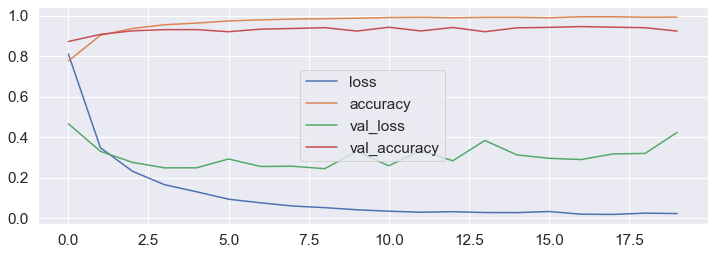

In [20]:
##vediamo graficamente la convergenza 

print("rete non convoluzionale ")
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

rete convoluzionale 


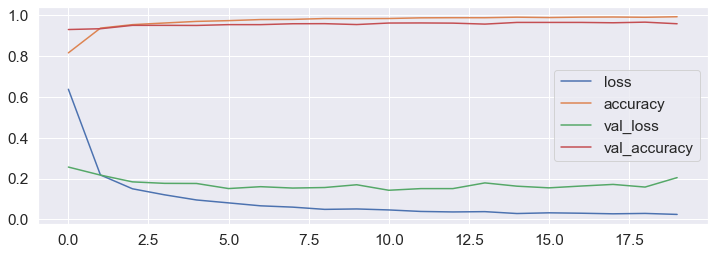

In [21]:
print("rete convoluzionale ")
pd.DataFrame(history_C.history).plot(figsize=(12,4))
plt.grid(True)


In [12]:
##ed infinse confrontiamo le due confusion matrix 



C:\Users\vigan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


non convoluzionale 


<AxesSubplot:>

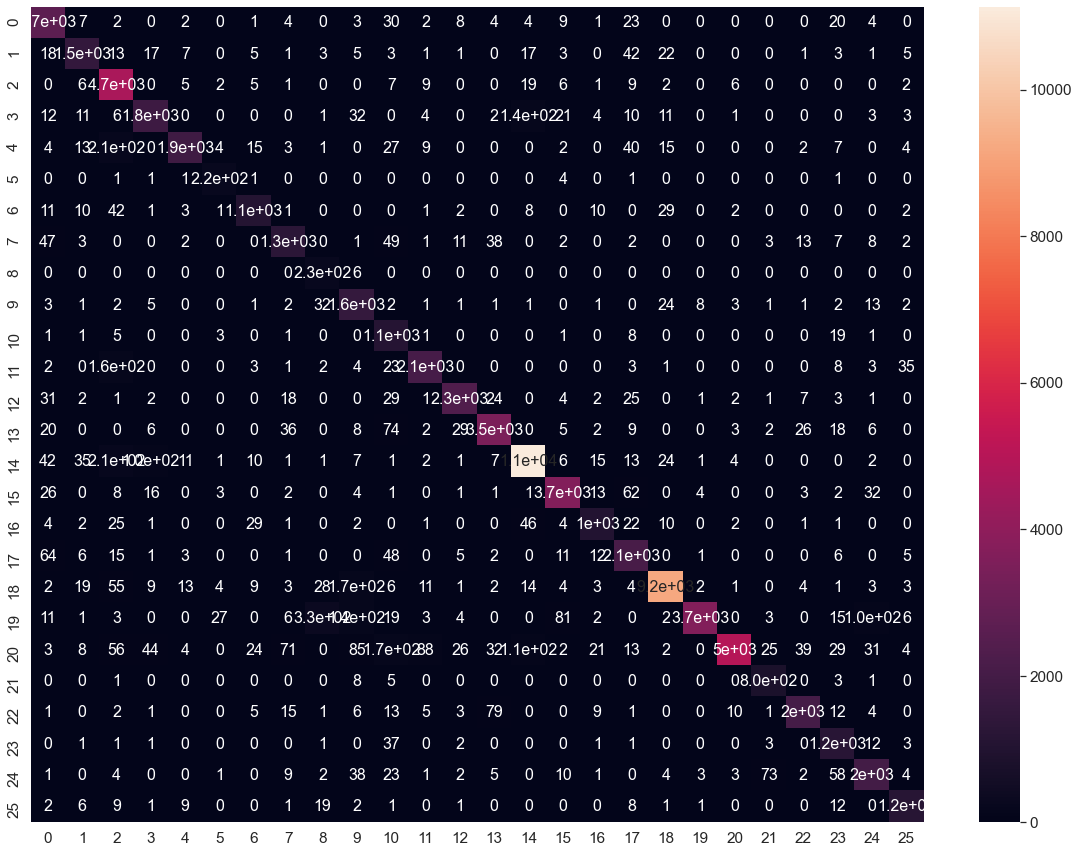

In [22]:
##confusion metrics  
y_pred = model.predict_classes(X_test)


#from sklearn.metrics import confusion_matrix
print("non convoluzionale ")

cm=confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(cm, range(26),range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size



convoluzionale 


C:\Users\vigan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<AxesSubplot:>

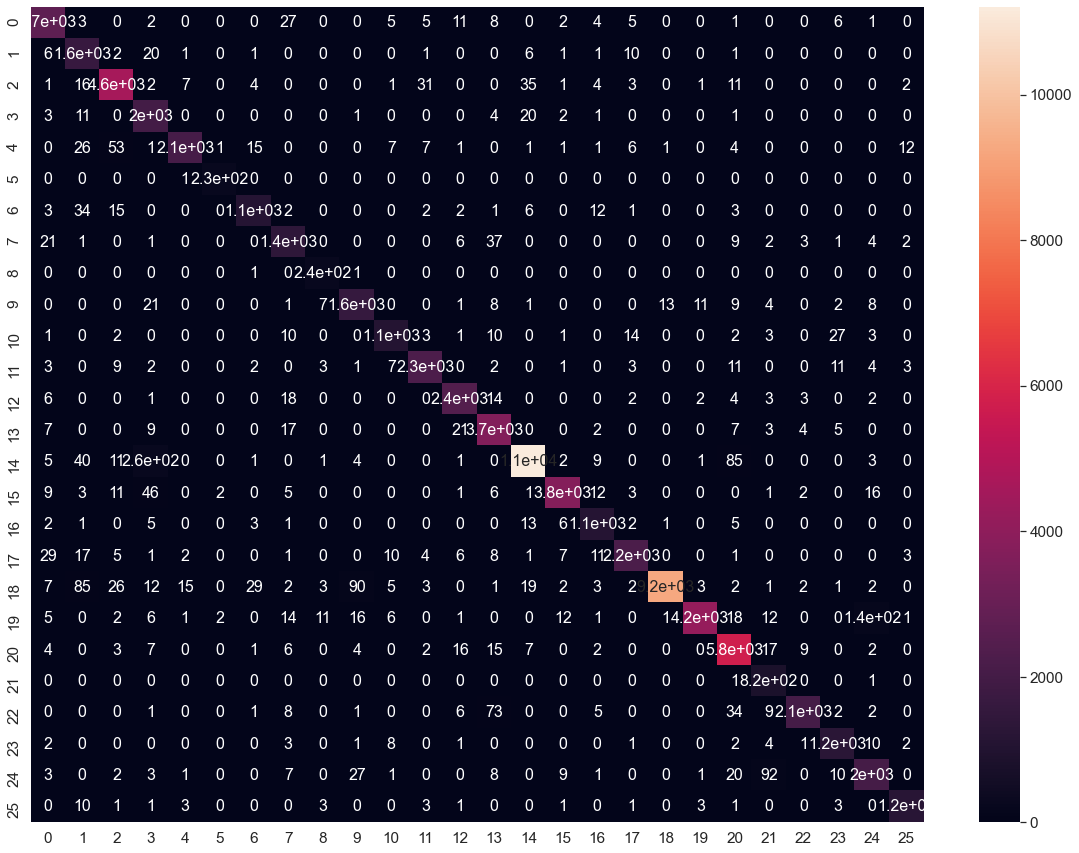

In [14]:
print("convoluzionale ")

y_pred_C = model_C.predict_classes(X_test_C)
rounded_labels=np.argmax(y_test_C, axis=1)
#rounded_predictions = model.predict_classes(X_test, batch_size=128, verbose=0)
cm_C = confusion_matrix(rounded_labels, y_pred_C)

df_cm = pd.DataFrame(cm_C, range(26),range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font sizeq